# Geospatial and Region Data
- Construct data relevant to attribute_region.csv here
- Assign population centroids
- Generate information relevant to average sunlight hours etc.

In [1]:
import datetime
import importlib
import inspect
import itertools
import geopandas as gpd
import logging
import matplotlib.pyplot as plt
import model_attributes as ma
import model_afolu as mafl
import model_ippu as mi
import model_circular_economy as mc
import model_electricity as ml
import model_energy as me
import model_socioeconomic as se
import setup_analysis as sa
import support_functions as sf
import numpy as np
import os, os.path
import owslib
from owslib.wcs import WebCoverageService
import pandas as pd
import pycountry
import pyproj
import re
import rioxarray as rx
import suntime
import time
from typing import *
import warnings

warnings.filterwarnings("ignore")


/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:2244: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")


# Read in applicable data

In [322]:
[x for x in list(df_countries["Nation"]) if "tai" in x.lower()]


[]

In [320]:
df_fao[~df_fao["Area"].isin(list(df_countries["Nation"]))].iloc[0:30]

,Area,Area Code
6,Anguilla,258
20,Belgium-Luxembourg,15
26,"Bonaire, Sint Eustatius and Saba",278
47,"China, mainland",41
48,"China, Taiwan Province of",214
52,Cook Islands,47
76,Falkland Islands (Malvinas),65
81,French Guyana,69
92,Guadeloupe,87
99,Holy See,94


In [295]:
pycountry.countries.search_fuzzy("Congo")
[x for x in list(df_countries["Nation"]) if "czec" in x.lower()]

['Czechia']

In [319]:
df_fao["Area"]
    
df_countries[~df_countries["Nation"].isin(list(df_fao["Area"]))].sort_values(by = ["Nation"])



,Nation,iso_code3,WB_Study,IDB_Study
211,Kosovo,XKX,NaN,NaN


In [323]:
attr_region.table

,category_name,region,iso_alpha_3,description,hourly_capacity_factor_region,powerplant_data,io_data,fao_area_code
0,Argentina,argentina,arg,NaN,Southern,Yes,Yes,9
1,Bahamas,bahamas,bhs,NaN,Northern,No,No,12
2,Barbados,barbados,brb,NaN,Equatorial,No,No,14
3,Belize,belize,blz,NaN,Equatorial,No,No,23
4,Bolivia,bolivia,bol,NaN,Southern,Yes,Yes,19
5,Brazil,brazil,bra,NaN,Southern,Yes,Yes,21
6,Chile,chile,chl,NaN,Southern,Yes,Yes,40
7,Colombia,colombia,col,NaN,Equatorial,Yes,Yes,44
8,Costa Rica,costa_rica,cri,NaN,Equatorial,Yes,Yes,48
9,Dominican Republic,dominican_republic,dom,NaN,Northern,Yes,Yes,56


In [330]:
# countries to drop



def get_countries_and_isos(
    fp_read_countries: str,
    fp_read_fao: str,
    field_code_fao: str = "Area Code",
    field_country_countries: str = "Nation",
    field_country_fao: str = "Area",
    field_code_fao_out: str = "fao_area_code", 
    field_iso_countries: str = "iso_code3",
    field_iso_out: str = "iso_alpha_3",
    field_name_category: str = "category_name",
    field_region: str = "region",
    missing_code_flag: int = -999
) -> pd.DataFrame:
    """
    Retrieve country data from external table of countries and ISO 
        (fp_read_countries) and FAO codes (fp_read_fao). Merges and 
        formats for use as region attribute table.
    
    Function Arguments
    ------------------
    - fp_read_countries: file path contaning countries and ISO codes
    - fp_read_fao: file path containing fao data used to merge in codes
    
    Keyword Arguments
    -----------------
    - field_code_fao: field in fp_read_fao that stores FAO code
    - field_country_countries: field in fp_read_countries used to store
        countries
    - field_country_fao: field in fp_read_fao used to store countries
    - field_code_fao_out: name of field to use for output FAO code
    - field_iso_countries: field in df_countries that contains ISO code
    - field_iso_out: field to assign to output dataframe
    - field_name_category: field used to store region names
    - field_region: field storing the SISEPUEDE region key (region)
    - missing_code_flag: flag for missing FAO code
    """
    countries_drop = [
        "Arab World", 
        "Caribbean small states",
        "High income",
        "South Asia"
    ]
    
    # names in FAO to replace
    dict_repl_fao = {
        "Bolivia (Plurinational State of)": "Bolivia",
        "China, Hong Kong SAR": "Hong Kong SAR, China",
        "China, Macao SAR": "Macao SAR, China",
        "Côte d'Ivoire": "Cote d'Ivoire",
        "Congo": "Republic of the Congo",
        "Curaçao": "Curacao",
        "Czechoslovakia": "Czechia",
        "Ethiopia PDR": "Ethiopia",
        "Iran (Islamic Republic of)": "Iran",
        "Venezuela (Bolivarian Republic of)": "Venezuela",
        "United Kingdom of Great Britain and Northern Ireland": "United Kingdom"
    }

    # dict in countries import to replace
    dict_repl_countries = {
        "Congo, Rep.": "Republic of the Congo",
        "Congo, Dem. Rep.": "Democratic Republic of the Congo",
        "Korea, Dem. People's Rep.": "Democratic People's Republic of Korea",
        "Kyrgyz Republic": "Kyrgyzstan",
        "Micronesia, Fed. Sts.": "Micronesia (Federated States of)",
        "Yemen, Rep.": "Yemen",
        "Vietnam": "Viet Nam",
        "United States": "United States of America",
        "Tanzania": "United Republic of Tanzania",
        "St. Martin (French part)": "Saint-Martin (French part)",
        "Lao PDR": "Lao People's Democratic Republic",
        "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
        "Virgin Islands (U.S.)": "United States Virgin Islands",
        "St. Kitts and Nevis": "Saint Kitts and Nevis",
        "Slovak Republic": "Slovakia",
        "St. Lucia": "Saint Lucia",
        "Gambia, The": "Gambia",
        "Korea": "Republic of Korea",
        "Moldova": "Republic of Moldova"
    }
    
    
    ##  READ IN COUNTRY & ISO
    
    df_countries = pd.read_csv(fp_read_countries)
    df_countries = df_countries[
        ~df_countries[field_country_countries].isin(countries_drop)
    ].reset_index(drop = True)
    df_countries[field_country_countries].replace(
        dict_repl_countries,
        inplace = True
    )
    
    
    ##  READ IN FAO DATA
    
    df_fao = pd.read_csv(
        fp_read_fao,
        encoding = "ISO-8859-1"
    )
    
    df_fao = df_fao[[field_country_fao, field_code_fao]].drop_duplicates().reset_index(drop = True)
    df_fao[field_country_fao].replace(
        dict_repl_fao, 
        inplace = True
    )
    
    
    ##  merge
    
    # renaming dictionaries
    dict_rnm_countries = {
        field_iso_countries: field_iso_out,
        field_country_countries: field_name_category
    }
    # FAO rnm
    dict_rnm_fao = {
        field_code_fao: field_code_fao_out,
        field_country_fao: field_name_category
    }
    
    # merge and sort etc.
    df_region = pd.merge(
        df_countries.rename(columns = dict_rnm_countries),
        df_fao.rename(columns = dict_rnm_fao),
        how = "left"
    )
    
    # fill NAs 
    df_region[field_code_fao_out].fillna(missing_code_flag, inplace = True)
    df_region[field_code_fao_out] = df_region[field_code_fao_out].astype(int)
    
    
    ##  BUILD REGION KEY (INITIAL) BY CLEANING AND REPLACING ANY NAMES
    
    df_region[field_region] = sf.clean_field_names(list(df_countries_sorted[field_name_category]))
    
    return df_region
    
    
    
    
    

# country with iso 
df_countries_sorted = get_countries_and_isos(
    "/Users/jsyme/Downloads/Countries_ISO3.csv",
    "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/ingestion/FAOSTAT/Inputs_LandUse_E_All_Data_(Normalized)/Inputs_LandUse_E_All_Data_(Normalized).csv"
)


df_countries_sorted

,category_name,iso_alpha_3,WB_Study,IDB_Study,fao_area_code
0,Aruba,ABW,NaN,NaN,22
1,Afghanistan,AFG,NaN,NaN,2
2,Angola,AGO,NaN,NaN,7
3,Albania,ALB,NaN,NaN,3
4,Andorra,AND,NaN,NaN,6
...,...,...,...,...,...
213,Kosovo,XKX,NaN,NaN,-999
214,Yemen,YEM,NaN,NaN,249
215,South Africa,ZAF,NaN,NaN,202
216,Zambia,ZMB,NaN,NaN,251


['aruba',
 'afghanistan',
 'angola',
 'albania',
 'andorra',
 'united_arab_emirates',
 'argentina',
 'armenia',
 'american_samoa',
 'antigua_and_barbuda',
 'australia',
 'austria',
 'azerbaijan',
 'burundi',
 'belgium',
 'benin',
 'burkina_faso',
 'bangladesh',
 'bulgaria',
 'bahrain',
 'bahamas',
 'bosnia_and_herzegovina',
 'belarus',
 'belize',
 'bermuda',
 'bolivia',
 'brazil',
 'barbados',
 'brunei_darussalam',
 'bhutan',
 'botswana',
 'central_african_republic',
 'canada',
 'switzerland',
 'channel_islands',
 'chile',
 'china',
 "cote_d'ivoire",
 'cameroon',
 'democratic_republic_of_the_congo',
 'republic_of_the_congo',
 'colombia',
 'comoros',
 'cabo_verde',
 'costa_rica',
 'cuba',
 'curacao',
 'cayman_islands',
 'cyprus',
 'czechia',
 'czechia',
 'germany',
 'djibouti',
 'dominica',
 'denmark',
 'dominican_republic',
 'algeria',
 'ecuador',
 'egypt',
 'eritrea',
 'spain',
 'estonia',
 'ethiopia',
 'ethiopia',
 'finland',
 'fiji',
 'france',
 'faroe_islands',
 'micronesia_(federa

# Data sources
- NASA SEDAC: 
    - UN WPP-Adjusted Population Count
        - Year 2020, 30-second resolution, ASCII
        - https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11/data-download
    - SEDAC National Identifier GRID
        - Year 2020, 30-second resolution, ASCII
        - https://sedac.ciesin.columbia.edu/data/set/gpw-v4-national-identifier-grid-rev11/data-download
    

In [24]:

def get_dict_from_lines(
    lines: List[str],
    splitter: Union[str, None] = None
) -> Union[Dict, None]:
    """
    Return a dictionary for use in converting an ascii input to arrays.
    
    Function Arguments
    ------------------
    - lines: list of input lines directly read from file (strings)
    
    Keyword Arguments
    -----------------
    - spltter: string to split on. If None, splits on whitespace
    """
    
    dict_out = {}
    
    for i, line in enumerate(lines):
        
        tup = line.strip().split(splitter)
        key, val = (tup[0], tup[1]) if (len(tup) == 2) else (tup, None)

        key = str(key)
        val = sf.tryparse_str_to_num(val)
        

        dict_out.update({key: val})
        
    return dict_out



def extract_country_weights(
    fp_population_ascii: str,
    fp_national_identifier: str,
    key_lat: str = "lat",
    key_lon: str = "lon",
    key_pop: str = "pop",
    pop_thresh: float = 0.0
) -> Dict:
    """
    Read weights for population center by country
    
    Function Arguments
    ------------------
    - fp_population_ascii: file path to ascii file for population
    - fp_national_identifier: file path to ascii file for national identifier
    
    Keyword Arguments
    -----------------
    - key_lat: key for element value dictionaries (each output key is associated 
        with a dictionary) for the vector of latitudes
    - key_lon: key for element value dictionaries (each output key is associated 
        with a dictionary) for the vector of longitudes
    - key_pop: key for element value dictionaries (each output key is associated 
        with a dictionary) for the vector of populations
    - pop_thresh: minimum threshold (weak) for identifying viable sets
    """
    
    print("Reading in population...")
    dict_info_pop, arr_pop = sf.read_ascii(fp_population_ascii)
    print("Done.")
    print("Reading in national identifiers...")
    dict_info_national_id, arr_national_id = sf.read_ascii(fp_national_identifier);
    print("Done.")
    
    # get some characteristics
    cell_size = dict_info_pop.get("cellsize")
    xllcorner = dict_info_pop.get("xllcorner")
    yllcorner = dict_info_pop.get("yllcorner")
    cell_size = dict_info_pop.get("cellsize")
    n_cols = dict_info_pop.get("ncols")
    n_rows = dict_info_pop.get("nrows")
    
    # check and return if invalid array shapes are found 
    if ((n_rows, n_cols) != arr_pop.shape) | ((n_rows, n_cols) != arr_national_id.shape):
        return None
    
    
    # identify non-zero populations and use as centroids
    w = np.where(arr_pop > pop_thresh)
    pops = arr_pop[w]
    lats = yllcorner + (n_rows - w[0] - 1)*cell_size + cell_size/2
    lons = xllcorner + w[1]*cell_size + cell_size/2
    
    # get countries
    ids = arr_national_id[w]
    all_ids = sorted(list(set(ids)))
    
    dict_out = {}
     
    for id_country in all_ids:
        if id_country > 0:
            w = np.where(ids == id_country)

            dict_out.update({
                id_country: {
                    key_lat: [np.dot(lats[w], pops[w])],
                    key_lon: [np.dot(lons[w], pops[w])],
                    key_pop: [pops[w].sum()]
                }
            })
        
    return dict_out



def get_population_centroid(
    dict_in: dict, 
    key_lat: str = "lat",
    key_lon: str = "lon",
    key_pop: str = "pop"
) -> Tuple:
    
    vec_lat = dict_in.get(key_lat)
    vec_lon = dict_in.get(key_lon)
    vec_pop = dict_in.get(key_pop)
    
    
    pop_total = sum(vec_pop)
    
    mean_lon = sum(vec_lon)/pop_total
    mean_lat = sum(vec_lat)/pop_total
    
    return (mean_lon, mean_lat)

# Calculate Population Centroids for Each Country

In [35]:
# setup directories for SEDAC population (adjusted) & National Identifiers
dir_pops = "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/General/nasa_sedac/gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11_2020_30_sec_asc"
dir_national_ids = "/Users/jsyme/Documents/Projects/FY21/SWCHE131_1000/Data/General/nasa_sedac/gpw-v4-national-identifier-grid-rev11_30_sec_asc"

# check population files available
regex_pops = re.compile("gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2020_30_sec_(\d*).asc")
fn_pops = [x for x in os.listdir(dir_pops) if regex_pops.match(x) is not None]
groups_pops = [sf.tryparse_str_to_num(regex_pops.match(x).groups()[0]) for x in fn_pops]

# check national ids
regex_national_ids = re.compile("gpw_v4_national_identifier_grid_rev11_30_sec_(\d*).asc")
fn_national_ids = [x for x in os.listdir(dir_national_ids) if regex_national_ids.match(x) is not None]
groups_national_ids = [sf.tryparse_str_to_num(regex_national_ids.match(x).groups()[0]) for x in fn_national_ids]

# get sectors available for pop and national identifiers
sectors = sorted(list(set(groups_pops) & set(groups_national_ids)))

# initialize output dictionary and keys for components
dict_countries = {}
key_lat: str = "lat"
key_lon: str = "lon"
key_pop: str = "pop"

t0 = time.time()
# loop over groups to read in avaiable data 
for sector in sectors:
    
    print(f"Starting SEDAC sector {sector}\n\n")
    
    fn_pops = regex_pops.pattern.replace("(\\d*)", str(sector))
    fp_pops = os.path.join(dir_pops, fn_pops)
    
    fn_n_ids = regex_national_ids.pattern.replace("(\\d*)", str(sector))
    fp_n_ids = os.path.join(dir_national_ids, fn_n_ids)
    
    dict_weights = extract_country_weights(
        fp_pops, 
        fp_n_ids,
        key_lat = key_lat,
        key_lon = key_lon,
        key_pop = key_pop
    )
    
    print(f"\tData extracted...")
    
    for k, v in dict_weights.items():
        
        if k not in dict_countries.keys():
            dict_countries.update({k: v})
            
        else:
            
            dict_cur = dict_countries.get(k)
            sv_keys = set(v.keys())
            
            if isinstance(dict_cur, dict):
                if sv_keys.issubset(set(dict_cur.keys())):
                    for v_key in list(sv_keys):
                        dict_cur[v_key] += v.get(v_key)
 
    t1 = time.time()
    rd = np.round(t1 - t0, decimals = 2)
    print(f"\nSEDAC sector {sector} complete.\n\n\tMark:\t{rd} seconds\n\n\n")




Starting SEDAC sector 1


Reading in population...
Done.
Reading in national identifiers...
Done.
	Data extracted...

SEDAC sector 1 complete.

	Mark:	19.94 seconds



Starting SEDAC sector 2


Reading in population...
Done.
Reading in national identifiers...
Done.
	Data extracted...

SEDAC sector 2 complete.

	Mark:	58.66 seconds



Starting SEDAC sector 3


Reading in population...
Done.
Reading in national identifiers...
Done.
	Data extracted...

SEDAC sector 3 complete.

	Mark:	113.4 seconds



Starting SEDAC sector 4


Reading in population...
Done.
Reading in national identifiers...
Done.
	Data extracted...

SEDAC sector 4 complete.

	Mark:	163.11 seconds



Starting SEDAC sector 5


Reading in population...
Done.
Reading in national identifiers...
Done.
	Data extracted...

SEDAC sector 5 complete.

	Mark:	184.73 seconds



Starting SEDAC sector 6


Reading in population...
Done.
Reading in national identifiers...
Done.
	Data extracted...

SEDAC sector 6 complete.

	Mark:	205.64 

# Next, get info table and build data frame with iso3 and population centroids

In [70]:
df_gpw_country_index = pd.read_csv(
    os.path.join(dir_national_ids, "gpw_v4_national_identifier_grid_rev11_lookup.txt"),
    sep = "\t"
)


def build_df_population_centroids_by_iso(
    df_gpw_country_index: pd.DataFrame,
    dict_countries: Dict,
    field_key_value: str = "Value",
    field_latitude: str = "latitude",
    field_longitude: str = "longitude",
    field_iso_stored: str = "ISOCODE",
    field_iso_write: str = "iso_code3"
) -> pd.DataFrame:
    """
    Read weights for population center by country
    
    Function Arguments
    ------------------
    - df_gpw_country_index: data frame containing codes (int) used as keys in
        the dictionary produced by readining in ASCIIs 
    - dict_countries: dictionary of form
    
        dict_countries = {
            country_key_0: {
                "lat": [lat_weighted_01, lat_weighted_01],
                "lon": [lon_weighted_01, lon_weighted_01],
                "pop": [p01, p02]
            },
            
            country_key_1: ...
        }
        
    
    Keyword Arguments
    -----------------
    - field_key_value: field in df_gpw_country_index containing the keys of 
        dict_countries
    - field_latitude: output field for latitude
    - field_longitude: output field for longitude
    - field_iso_stored: field containing 3-digit ISO codes in df_gpw_country_index
    - field_iso_write: field to which 3-digit ISO codes will be written in output
    """
    
    dict_gpw = sf.build_dict(df_gpw_country_index[[field_key_value, field_iso_stored]])
    df_out = []
    
    for k in dict_countries.keys():
        
        key = int(k)
        
        iso = dict_gpw.get(key)
        if (iso is not None):
            iso = str(iso) 
            tup_lon_lat = get_population_centroid(dict_countries.get(k))
            
            df_out.append([iso, tup_lon_lat[0], tup_lon_lat[1]])
            
    
    df_out = (
        pd.DataFrame(
            df_out, 
            columns = [field_iso_write, field_longitude, field_latitude]
        )
        .sort_values(by = [field_iso_write])
        .reset_index(drop = True)
    )
        
    return df_out


df_pop_centroids_by_iso = build_df_population_centroids_by_iso(
    df_gpw_country_index, 
    dict_countries
)

(
    df_pop_centroids_by_iso
    .to_csv(
        sa.fp_csv_population_centroids_by_iso,
        index = None,
        encoding = "UTF-8"
    )
)



# Next, for energy, identify sunrise/sunset time by time slice group (associated with months)
- Used in solar availability
- In next step, will be used to adjust demands intra-annually
- As much as I'd like to code it up, someone has done it:
    - https://pypi.org/project/suntime/
- Assumption about 3.5 from 0.5 hr after sunrise to peak, then 2 hr from peak to 0.5 before sunset
    - https://www.researchgate.net/figure/The-start-stop-and-peak-of-solar-generation-red-approximates-the-time-of-sunrise_fig1_310821721
    

In [161]:
import timezonefinder as tzf
import pytz
tf = tzf.TimezoneFinder()


In [184]:
tz_test = tf.timezone_at(lat = cur[1], lng = cur[2])
tz_pytz = pytz.timezone(tz_test)


In [186]:
tz_pytz.utcoffset(datetime.datetime(2026, 4, 19))


datetime.timedelta(days=-1, seconds=68400)

In [189]:
import dateutil
#dateutil.tz.tzutc
dt = datetime.datetime(2026, 4, 19)
delta = tz_pytz.utcoffset(dt)

dt - delta

datetime.datetime(2026, 4, 19, 5, 0)

In [146]:

ss_try = suntime.Sun(37.303899, -92.451674)
ss_try.get_sunset_time(datetime.datetime(2026, 6, 21, tzinfo = tz_test))

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'str'

In [4]:

df_pop_centroids_by_iso = pd.read_csv(sa.fp_csv_population_centroids_by_iso)

In [253]:
year = 2025
import batch_data_support_regions as bds_reg
importlib.reload(bds_reg)

cur = list(df_pop_centroids_by_iso[["iso_code3", "latitude", "longitude"]].iloc[161])
#cur = list(df_pop_centroids_by_iso[["iso_code3", "latitude", "longitude"]].iloc[226])
region_test = bds_reg.region_solar(*cur)



In [254]:
region_test.build_solar_cf_seasonal_component_by_hour(sa.model_attributes)

,hour,dec_feb,mar_may,jun_aug,sep_nov,hour_group
0,0,0.000000,0.000000,0.000000,0.000000,0
1,1,0.000000,0.000000,0.000000,0.000000,0
2,2,0.000000,0.000000,0.000000,0.000000,0
3,3,0.000000,0.000000,0.000000,0.000000,0
4,4,0.000000,0.000000,0.103175,0.000000,6
5,5,0.000000,0.103175,0.388889,0.000000,6
6,6,0.000000,0.388889,0.674603,0.000000,6
7,7,0.000000,0.674603,0.908730,0.000000,6
8,8,0.000000,0.908730,1.000000,0.103175,6
9,9,0.000000,1.000000,1.000000,0.388889,6


In [252]:
attr_hour = sa.model_attributes.dict_attributes.get("hour")
attr_hour.table

,hour,hour_group
0,0,0
1,1,0
2,2,0
3,3,0
4,4,6
5,5,6
6,6,6
7,7,6
8,8,6
9,9,6


In [247]:
df_pop_centroids_by_iso[
    df_pop_centroids_by_iso["iso_code3"].isin(["SWE"])
]

,iso_code3,longitude,latitude
203,SWE,15.540582,58.813979


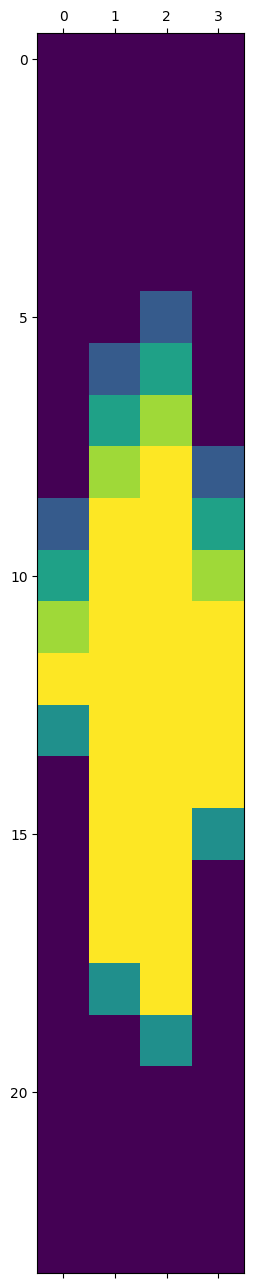

In [248]:
year = 2025
import batch_data_support_regions as bds_reg
importlib.reload(bds_reg)

cur = list(df_pop_centroids_by_iso[["iso_code3", "latitude", "longitude"]].iloc[203])
#cur = list(df_pop_centroids_by_iso[["iso_code3", "latitude", "longitude"]].iloc[226])
region_test = bds_reg.region_solar(*cur)
tt = region_test.build_solar_cf_seasonal_component_by_hour(sa.model_attributes, explode_by_year = True).iloc[0:24]



region_test.build_solar_seasonality_curve(datetime.date(2026, 6, 21))

arr = np.array(tt[[x for x in tt.columns if x not in ["year", "hour"]]])

plt.matshow(arr)



In [77]:
region_test.sun.get_sunset_time(datetime.date(2026, 6, 21))

datetime.datetime(2026, 6, 21, 21, 0, tzinfo=tzutc())

In [80]:
region_test.build_solar_seasonality_curve(
    datetime.date(2026, 12, 21),
    #h_shift_last_to_sunet = 0.4,
    return_type = "data_frame"
)  
    
    
    

8
14


,hour,factor
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,0.000000
7,7,0.000000
8,8,0.000000
9,9,0.285714


In [14]:
import datetime
time_obj = datetime.date(2026, 12, 21)
region_test.sun.get_sunrise_time(time_obj)

datetime.datetime(2026, 12, 21, 8, 33, tzinfo=tzutc())

In [53]:
# list(df_pop_centroids_by_iso[["iso_code3", "latitude", "longitude"]].iloc[161])
dt = region_test.sun.get_sunset_time(time_obj)
dt.hour

14

In [54]:
type(time_obj)

datetime.date

datetime.datetime(2026, 11, 15, 7, 24, tzinfo=tzutc())

In [52]:
df_gpw_country_index[df_gpw_country_index["Value"].isin([124, 643, 840, 218])]


,Value,ISOCODE,UNSDCODE,NAME0,CIESINCODE,DATATYPE,DATACODE,DATAYEAR,DATALEVEL,SEXLEVEL,AGELEVEL,GRSTART,GREND,GRLEVEL,LASTCENSUS,MEANUNITKM
33,124,CAN,124,Canada,124,Final census,1,2011,5,3,3,2006,2011,2,2016,111089.742300
57,218,ECU,218,Ecuador,218,Final census,1,2010,3,3,3,2001,2010,1,2010,1460.578889
175,643,RUS,643,Russian Federation,643,Final census,1,2010,3,1,1,2002,2010,1,2010,201128.549200
230,840,USA,840,United States of America,840,Final census,1,2010,5,5,5,2000,2010,2,2010,1090.861659


In [60]:
df_gpw_country_index[df_gpw_country_index["ISOCODE"].isin(["BRA"])]


,Value,ISOCODE,UNSDCODE,NAME0,CIESINCODE,DATATYPE,DATACODE,DATAYEAR,DATALEVEL,SEXLEVEL,AGELEVEL,GRSTART,GREND,GRLEVEL,LASTCENSUS,MEANUNITKM
22,76,BRA,76,Brazil,76,Final census,1,2010,5,5,5,2000,2010,2,2010,1886.892649
